In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from itertools import count
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Run interactively

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from runner import Runner

In [4]:
run = Runner("wildstyle", "~/.local/src/celeritas/build-opt")

In [5]:
result = run(2**12)
print("Completed", result['run']['num_tracks'], "tracks in", result['result']['total_time'], "seconds")

Completed 4096 tracks in 0.00677831 seconds


In [6]:
sum(result['result']['alive'])

230423

## Analyze

In [25]:
labels = {
    '4e042b6': 'Original',
    '6689fb1': 'Remove extra synchronize',
    '7056d23': 'Remove grid striding',
    #'3baa35d': 'Move-to-collision function', # no change
    '6fd742d': 'Local memory for pos/dir/time',
    '0a48e78': 'Local memory for RNG',
    '2aa6936': 'Rearrange view declarations',
    '48e45ec': 'Split into move/interact kernels',
    'f42388c': 'Split into move/interact/cutoff kernels',
}

In [26]:
from pathlib import Path

slc = slice(0, 26)

def load_one(dirname):
    with open(Path(dirname) / 'results.json', 'r') as f:
        results = json.load(f)
    kernels = results['final_result']['runtime']['kernels']
    for k in ['iterate', 'interact']:
        try:
            stats = kernels[k]
        except KeyError:
            continue
        else:
            break
    else:
        stats = {}
            
    return {
        'tracks': np.array(results['num_tracks'])[slc],
        'time': np.array(results['time'])[slc],
        'sum_steps': np.array(results['steps'])[slc],
        'max_steps': len(results['final_result']['result']['alive']),
        'stats': stats,
    }

In [27]:
results = {k: load_one(k) for k in labels}

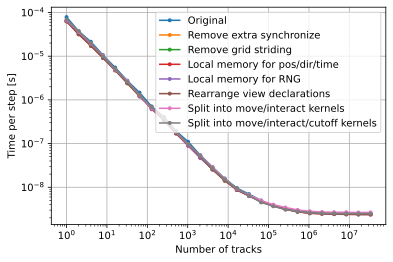

In [28]:
(fig, ax) = plt.subplots(subplot_kw=dict(xscale='log', yscale='log'))
for k in labels:
    r = results[k]
    ax.plot(r['tracks'], r['time'] / r['sum_steps'], marker='.', label=labels[k])
ax.grid()

ax.set_xlabel("Number of tracks")
ax.set_ylabel("Time per step [s]")
ax.legend();

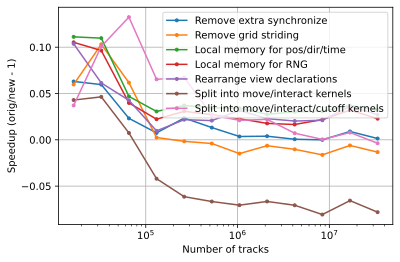

In [29]:
(fig, ax) = plt.subplots(subplot_kw=dict(xscale='log'))
changes_k = list(labels)
ref_k = changes_k.pop(0)
ref_tracks = results[ref_k]['tracks']
slc = ref_tracks > 1e4
ref_tracks = ref_tracks[slc]
ref_time = results[ref_k]['time'][slc]

for k in changes_k:
    r = results[k]
    ax.plot(ref_tracks, ref_time / r['time'][slc] - 1, marker='.', label=labels[k])
ax.grid()
ax.set_xlabel("Number of tracks")
ax.set_ylabel("Speedup (orig/new - 1)")
ax.legend();

In [30]:
num_steps = next(iter(results.values()))['sum_steps'][-1]
assert all(r['sum_steps'][-1] == num_steps for r in results.values())

AssertionError: 

In [13]:
[r['sum_steps'][-1] for r in results.values()]

[1920713596,
 1920713596,
 1920713596,
 1920713596,
 1920713596,
 1920713596,
 1920713596,
 1887159164]

In [14]:
{labels[k]: r['time'][-1] for (k, r) in results.items()}

{'Original': 4.699649543,
 'Remove extra synchronize': 4.693107337,
 'Remove grid striding': 4.763002573,
 'Local memory for pos/dir/time': 4.552279311,
 'Local memory for RNG': 4.594771157,
 'Rearrange view declarations': 4.575431935,
 'Split into move/interact kernels': 5.098160785,
 'Split into move/interact/cutoff kernels': 7.010716611}

In [15]:
{labels[k]: r['max_steps'] for (k, r) in results.items()}

{'Original': 99,
 'Remove extra synchronize': 99,
 'Remove grid striding': 99,
 'Local memory for pos/dir/time': 99,
 'Local memory for RNG': 99,
 'Rearrange view declarations': 99,
 'Split into move/interact kernels': 99,
 'Split into move/interact/cutoff kernels': 98}

In [16]:
occupancy = [r['stats']['occupancy'] for r in results.values()]

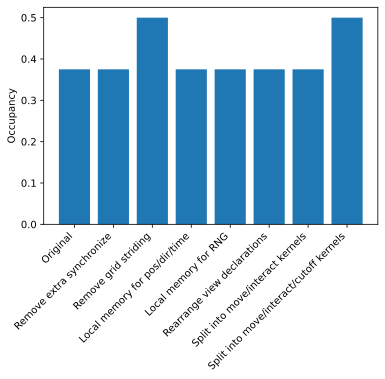

In [24]:
(fig, ax) = plt.subplots()
olabels = [labels[k] for k in results]
x_ = np.arange(len(olabels))
ax.bar(x_, occupancy)
ax.set_xticks(x_)
ax.set_xticklabels(olabels, rotation=45, ha='right')
ax.set_ylabel('Occupancy');

In [72]:
{labels[k]: r['stats'] for (k, r) in results.items()}

{'Original': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 68,
  'occupancy': 0.375},
 'Remove extra synchronize': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 68,
  'occupancy': 0.375},
 'Remove grid striding': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 64,
  'occupancy': 0.5},
 'Local memory for pos/dir/time': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 68,
  'occupancy': 0.375},
 'Local memory for RNG': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads': 67108864,
  'num_launches': 98,
  'num_regs': 70,
  'occupancy': 0.375},
 'Rearrange view declarations': {'block_size': 256,
  'const_mem': 344,
  'local_mem': 48,
  'max_num_threads':